In [12]:
from torch.utils.data import DataLoader, random_split
from dataset import ProteinDataset
import torch
import torch.utils.data as data_utils

dataset = ProteinDataset('/gpfs/space/home/donatasv/semester_3/biological_data/project/data/preprocessed_small/biological_process_data.pkl')

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 2048
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
from torch.utils.data import DataLoader, Subset
from dataset import ProteinDataset
import torch
import numpy as np

def oversample_indices(dataset, indices):
    go_vectors = torch.stack([dataset.go_vectors[idx] for idx in indices])
    class_counts = go_vectors.sum(dim=0)
    
    if torch.any(class_counts == 0):
        print("Warning: Some classes have no instances. Adjusting counts to avoid division by zero.")
        class_counts = torch.where(class_counts == 0, 1, class_counts)
    
    max_count = torch.max(class_counts)
    oversampling_rates = max_count / class_counts

    oversampled_indices = []
    for idx in indices:
        go_vector = dataset.go_vectors[idx]
        
        replication_factors = (oversampling_rates * go_vector).ceil()
        max_replication_factor = torch.max(replication_factors).int().item()
        
        if max_replication_factor > 0:
            oversampled_indices.extend([idx] * max_replication_factor)
        else:
            oversampled_indices.append(idx)

    return oversampled_indices

dataset = ProteinDataset('/gpfs/space/home/donatasv/semester_3/biological_data/project/data/preprocessed_small/biological_process_data.pkl')

total_indices = list(range(len(dataset)))
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

torch.manual_seed(42)
train_indices = torch.randperm(len(dataset))[:train_size].tolist()
val_indices = torch.randperm(len(dataset))[train_size:train_size + val_size].tolist()

oversampled_train_indices = oversample_indices(dataset, train_indices)
train_dataset = Subset(dataset, oversampled_train_indices)
val_dataset = Subset(dataset, val_indices)

batch_size = 2048
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [13]:
dataset[0], len(dataset)

({'sequence': 'MAQLCGLRRSRAFLALLGSLLLSGVLAADRERSIHDFCLVSKVVGRCRASMPRWWYNVTDGSCQLFVYGGCDGNSNNYLTKEECLKKCATVTENATGDLATSRNAADSSVPSAPRRQDSEDHSSDMFNYEEYCTANAVTGPCRASFPRWYFDVERNSCNNFIYGGCRGNKNSYRSEEACMLRCFRQQENPPLPLGSKVVVLAGLFVMVLILFLGASMVYLIRVARRNQERALRTVWSSGDDKEQLVKNTYVL',
  'embeddings': tensor([-0.0278,  0.0341,  0.0560,  ..., -0.0240, -0.0065,  0.0416]),
  'go_vector': tensor([0., 0., 0.,  ..., 0., 0., 0.])},
 1607389)

In [8]:
# class MultiHeadSelfAttention(nn.Module):
#     def __init__(self, embed_size, heads):
#         super(MultiHeadSelfAttention, self).__init__()
#         self.attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=heads, batch_first=True)
#         self.fc_out = nn.Linear(embed_size, embed_size)
#         self.norm = nn.LayerNorm(embed_size)

#     def forward(self, value, key, query):
#         attention_out, _ = self.attention(query, key, value)
#         out = self.fc_out(attention_out)
#         out = self.norm(out)
#         return out

# class LSTMWithSelfAttention(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, num_heads):
#         super(LSTMWithSelfAttention, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
        
#         self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
#         self.self_attention = MultiHeadSelfAttention(hidden_dim, num_heads)
#         self.dropout = nn.Dropout(dropout)
#         self.fc = nn.Linear(hidden_dim, output_dim)
#         self.norm1 = nn.LayerNorm(hidden_dim)
#         self.norm2 = nn.LayerNorm(hidden_dim)

#     def forward(self, x):
#         x = x.unsqueeze(-1)  # Reshape from [batch_size, 1024] to [batch_size, 1024, 1]
        
#         lstm_out, _ = self.lstm(x)
#         lstm_out = lstm_out[:, :-1, :] # Take last output from LSTM
#         lstm_out = self.norm1(lstm_out)  
#         print(lstm_out.shape)

#         # needs activation func
        
#         attention_out = self.self_attention(lstm_out, lstm_out, lstm_out)
#         attention_out = self.norm2(attention_out)
        
#         out = self.dropout(lstm_out)
#         print(out.shape)
#         out = self.fc(out)  # Take the output of the last time step
#         return torch.sigmoid(out)  # Sigmoid activation to get probabilities for each class


# input_dim = len(dataset[0]['embeddings'])
# hidden_dim = 512
# output_dim = len(dataset[0]['go_vector'])
# num_layers = 2
# dropout = 0.5
# num_heads = 8

# # Model
# model = LSTMWithSelfAttention(input_dim, hidden_dim, output_dim, num_layers, dropout, num_heads)


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNet1DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResNet1DBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet1D(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ResNet1D, self).__init__()
        
        self.initial_conv = nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.initial_bn = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, blocks=2)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
            )

        layers = []
        layers.append(ResNet1DBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResNet1DBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.initial_bn(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

input_channels = 1
num_classes = len(dataset[0]['go_vector'])
model = ResNet1D(input_channels, num_classes)

# Example input tensor
input_tensor = torch.randn(1, input_channels, len(dataset[0]['embeddings']))
output = model(input_tensor)
print(output.size())

torch.Size([1, 2031])


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

learning_rate = 1e-3
num_epochs = 150
patience = 25 

loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

best_val_loss = float('inf')
epochs_no_improve = 0

fig, ax = plt.subplots()
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    print('epoch: {epoch}')
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader, position=0, leave=False, desc="train batch", ncols=80):
        inputs, labels = batch['embeddings'], batch['go_vector']
        inputs = torch.unsqueeze(inputs, 1).to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs.float())
        outputs = torch.sigmoid(outputs)
        loss = loss_function(outputs, labels.float())
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()

    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, position=0, leave=False, desc="val batch", ncols=80)::
            inputs, labels = batch['embeddings'], batch['go_vector']
            inputs = torch.unsqueeze(inputs, 1).to(device)
            labels = labels.to(device)
            
            outputs = model(inputs.float())
            outputs = torch.sigmoid(outputs)
            loss = loss_function(outputs, labels.float())
            total_val_loss += loss.item()

    train_loss_avg = total_train_loss / len(train_loader)
    val_loss_avg = total_val_loss / len(val_loader)
    train_losses.append(train_loss_avg)
    val_losses.append(val_loss_avg)

    # Reduce LR on plateau
    scheduler.step(val_loss_avg)

    # Early stopping check
    print(f'Epoch: {epoch}, Train loss: {train_loss_avg}, Val loss: {val_loss_avg}')
    
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        print(f'New best val loss at epoch {epoch}')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve == patience:
        print("Early stopping triggered.")
        break


ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')
ax.legend()

# Save the model
torch.save(model.state_dict(), 'protein_classification_model_2.pth')

In [7]:
model.load_state_dict(torch.load('protein_classification_model.pth', map_location=device))
model = model.eval()

/gpfs/space/home/donatasv/.conda/envs/bcv_clickseg/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/space/home/donatasv/.conda/envs/bcv_clickseg/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/space/home/donatasv/.conda/envs/bcv_clickseg/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

              precision    recall  f1-score   support

           0       0.89      0.56      0.68        90
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         1
           4       0.75      0.30      0.43        10
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00         2
          11       1.00      0.22      0.36         9
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00         1
          15       1.00      0.11      0.20         9
          16       1.00      0.11      0.20         9
          17       0.00    

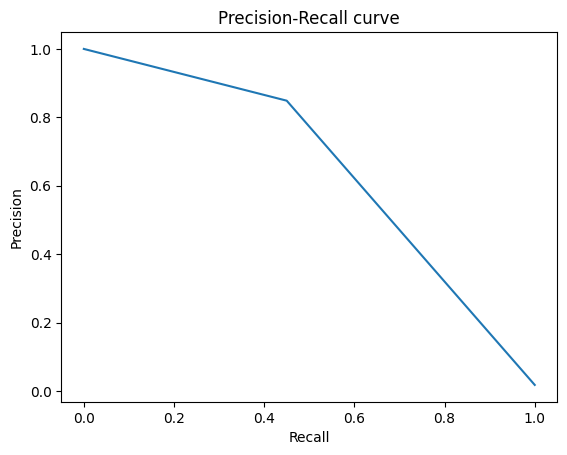

Precision-Recall AUC: 0.6541177986539208


In [8]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report, precision_recall_curve, f1_score, auc
import numpy as np

y_pred = []
y_true = []

with torch.no_grad():
    for batch in val_loader:
        inputs, labels = batch['embeddings'], batch['go_vector']
        inputs = torch.unsqueeze(inputs, 1).to(device)
        
        outputs = model(inputs.float())
        outputs = torch.sigmoid(outputs)  # Apply sigmoid to get predictions between 0 and 1
        
        # Convert outputs to binary predictions and labels to CPU
        predictions = (outputs > 0.5).int().cpu().numpy()
        labels = labels.cpu().numpy()
        
        y_pred.extend(predictions)
        y_true.extend(labels)

# Flattening the lists for sklearn metrics calculation
y_pred = np.vstack(y_pred)
y_true = np.vstack(y_true)

# Compute F1 score, precision, recall
precision, recall, f1, _ = score(y_true, y_pred, average=None)

# Classification report
print(classification_report(y_true, y_pred))

# Precision-Recall curve
precision_curve, recall_curve, _ = precision_recall_curve(y_true.ravel(), y_pred.ravel())
plt.plot(recall_curve, precision_curve)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

# Compute AUC for Precision-Recall curve
auc_pr = auc(recall_curve, precision_curve)
print(f'Precision-Recall AUC: {auc_pr}')
